In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pickle

In [14]:
# --- import

tw = pd.read_csv('data/tw_bankruptcy.csv')
us = pd.read_csv('data/combined.csv')

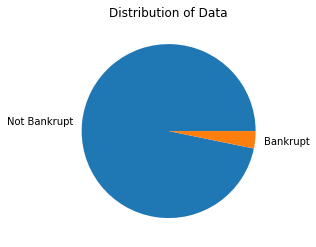

In [18]:
compare = tw.groupby(['Bankrupt?'])['Bankrupt?'].count()
plt.pie(compare, labels=['Not Bankrupt', 'Bankrupt'])
plt.title('Distribution of Data')
plt.show()

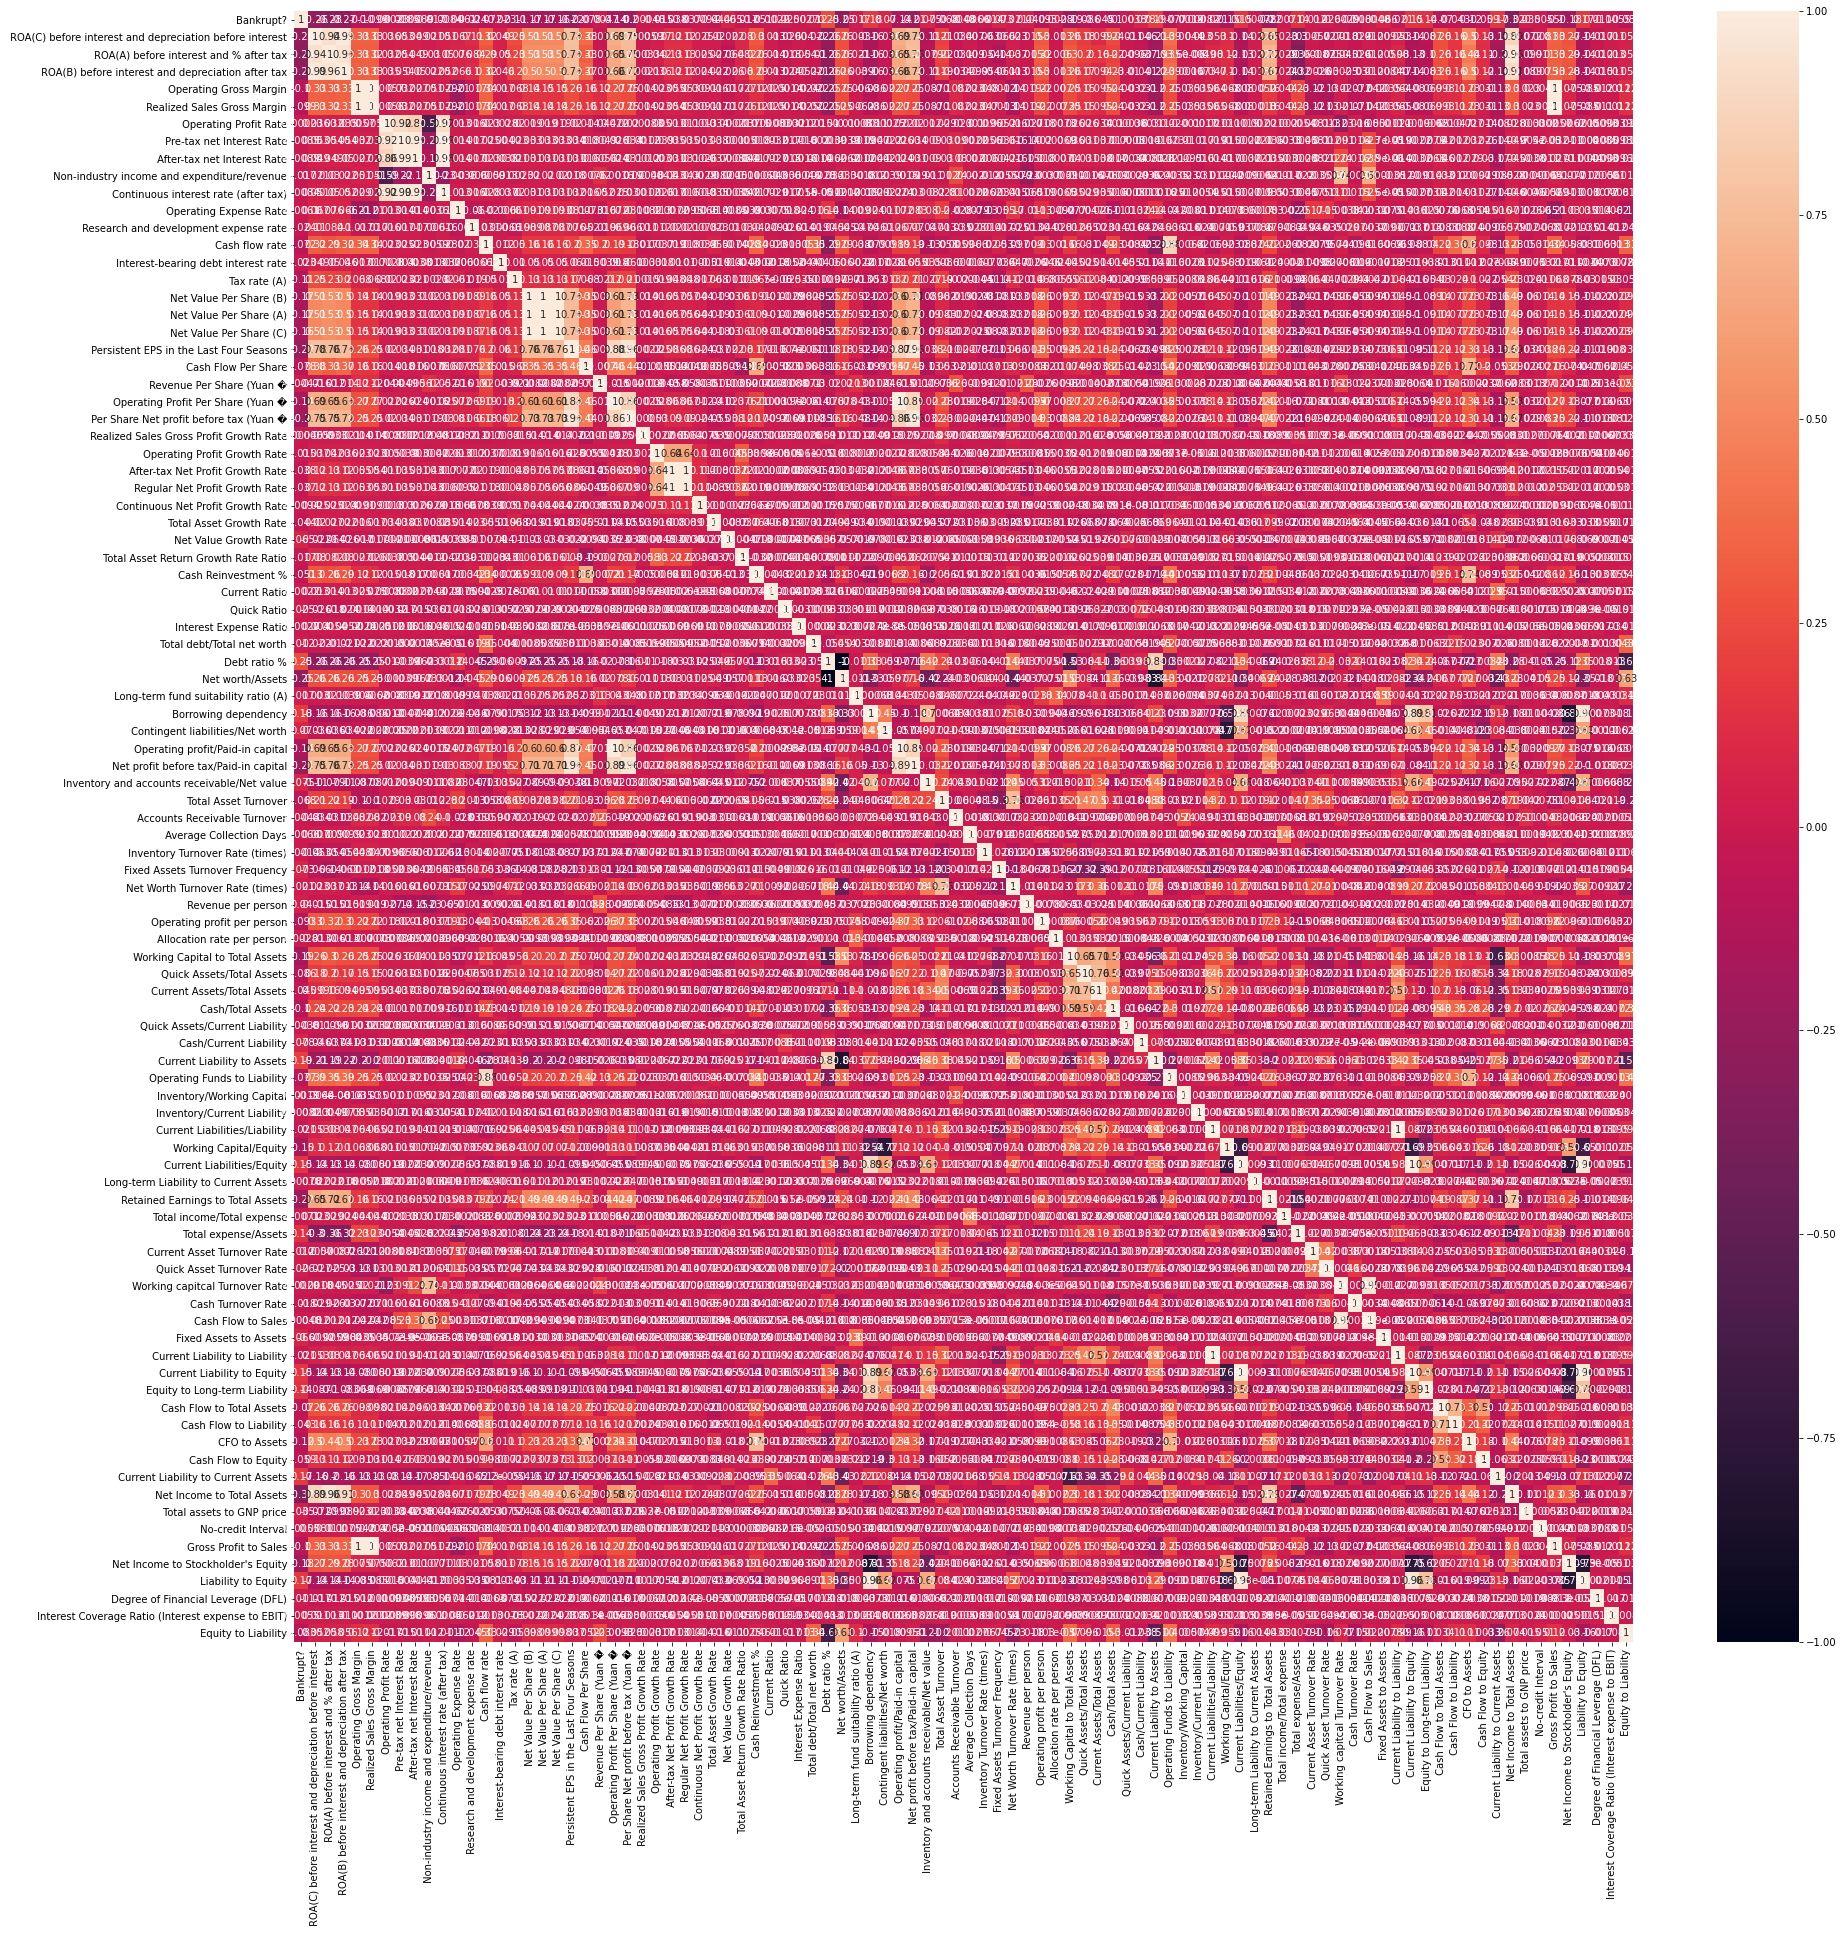

In [10]:
plt.figure(figsize=(30,30))
sns.heatmap(tw.corr(), annot=True)
plt.savefig('image/tw.corr.png')

In [4]:
# --- EDA tw data

compare = tw.groupby(['Bankrupt?']).mean().T
compare['difference'] = compare.iloc[:,1] - compare.iloc[:,0]
compare['%'] = round(compare.iloc[:,2]/compare.iloc[:,1],2)
compare.sort_values(by='%', ascending=False)

Bankrupt?,0,1,difference,%
Net Value Growth Rate,2.045765e+05,4.240909e+07,4.220451e+07,1.000000e+00
Fixed Assets to Assets,2.468865e-01,3.781818e+07,3.781818e+07,1.000000e+00
Revenue per person,1.335051e+06,3.204545e+07,3.071040e+07,9.600000e-01
Cash/Current Liability,2.989953e+07,2.549409e+08,2.250414e+08,8.800000e-01
Quick Ratio,7.257160e+06,4.195455e+07,3.469739e+07,8.300000e-01
...,...,...,...,...
Interest-bearing debt interest rate,1.690392e+07,2.772727e+06,-1.413120e+07,-5.100000e+00
Average Collection Days,1.013305e+07,6.227273e+05,-9.510323e+06,-1.527000e+01
Revenue Per Share (Yuan �,1.372935e+06,2.732298e-02,-1.372935e+06,-5.024837e+07
Current Ratio,4.167298e+05,7.237612e-03,-4.167298e+05,-5.757836e+07


In [11]:
tw = pd.read_csv('data/tw_clean.csv')
tw.head()

,Bankrupt?,Return on Assets,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Total Asset Turnover,Accounts Receivable Turnover,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Total income/Total expense,Total expense/Assets,Current Liability to Current Assets
0,1,0.424389,0.000327,0.002259,0.001208,0.021266,0.095885,0.137757,0.086957,0.001814,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.002022,0.064856,0.118250
1,1,0.538214,0.000443,0.006016,0.004039,0.012502,0.093743,0.168962,0.064468,0.001286,0.127236,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.002226,0.025516,0.047775
2,1,0.499019,0.000396,0.011543,0.005348,0.021248,0.092318,0.148036,0.014993,0.001495,0.340201,0.602806,0.000991,0.006302,5.340000e+09,0.098162,0.002060,0.021387,0.025346
3,1,0.451265,0.000382,0.004194,0.002896,0.009572,0.077727,0.147561,0.089955,0.001966,0.161575,0.225815,0.018851,0.002961,1.010646e-03,0.098715,0.001831,0.024161,0.067250
4,1,0.538432,0.000439,0.006022,0.003727,0.005150,0.096927,0.167461,0.175412,0.001449,0.260330,0.358380,0.014161,0.004275,6.804640e-04,0.110195,0.002224,0.026385,0.047725


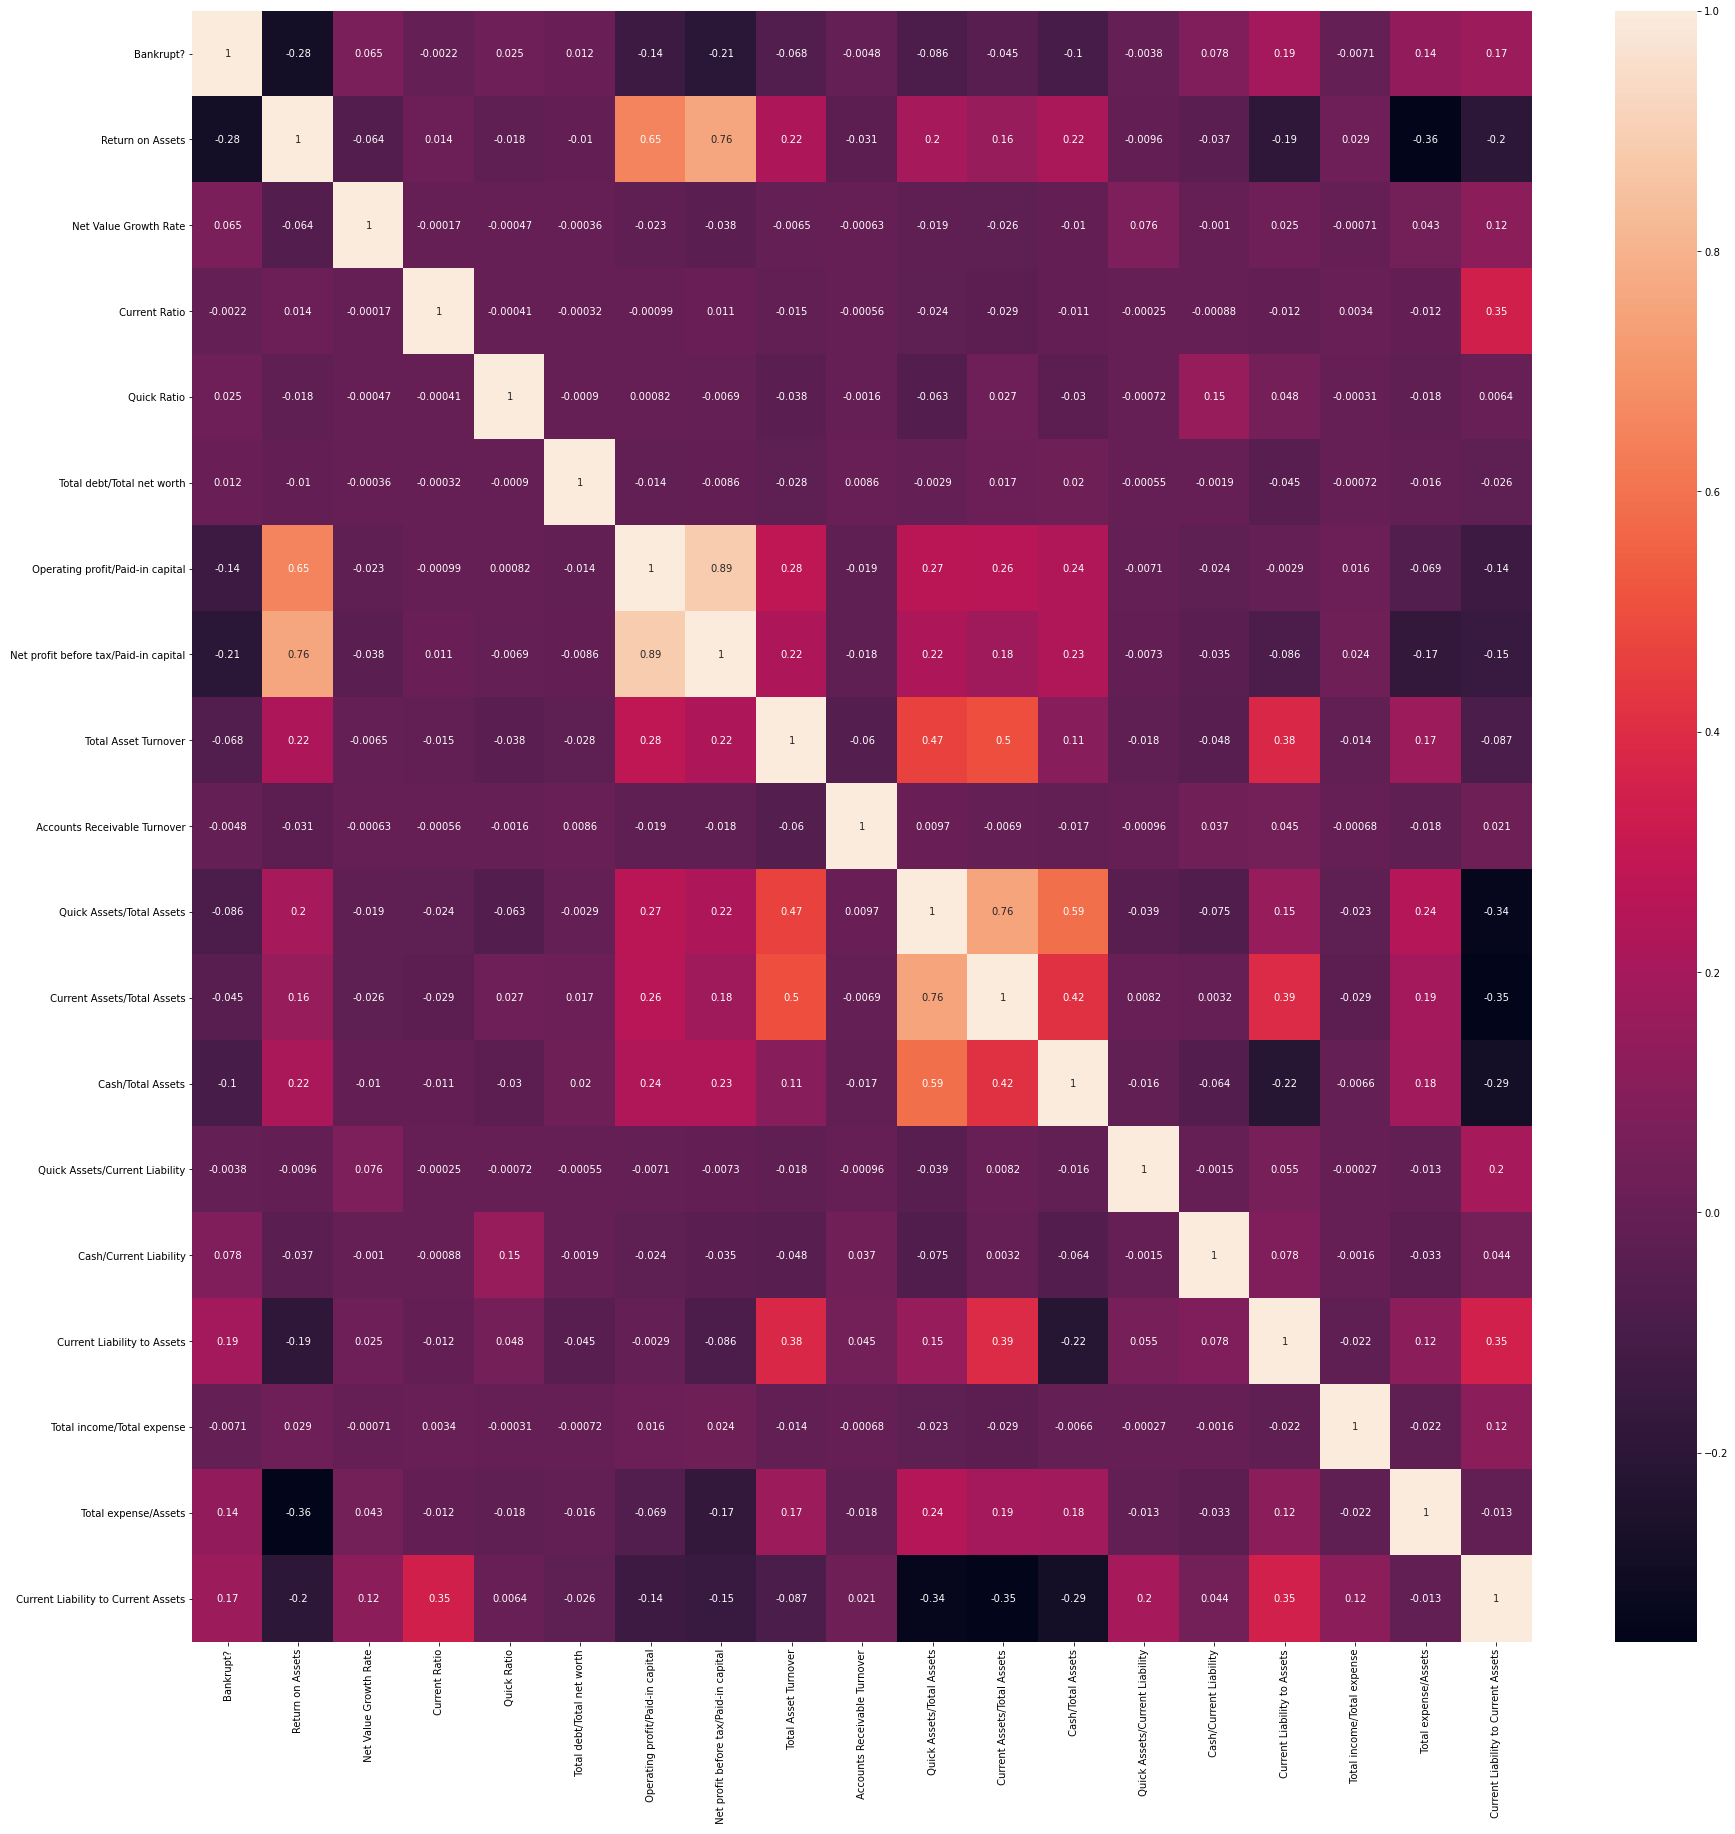

In [13]:
plt.figure(figsize=(30,30))
sns.heatmap(tw.corr(), annot=True)
plt.savefig('image/tw_clean.corr.png')

In [4]:
# --- Checking zero columns to avoid division to infinity
us['Total expense'] = us['grossProfit'] - us['netIncome']
divider = ['totalStockholdersEquity','totalAssets','totalCurrentLiabilities','totalCurrentAssets', 'Total expense']
us[divider][us[divider]==0].count()

totalStockholdersEquity     1787
totalAssets                  479
totalCurrentLiabilities    19762
totalCurrentAssets         22630
Total expense               6941
dtype: int64

In [5]:
us = us[(us[divider]!=0).all(axis=1)]
us

,Unnamed: 0,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,...,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,year_drop.3,Total expense
0,0,2021-03-31,CMCSA,USD,2021-04-29,2021-04-29 15:22:23,1,1.495000e+10,0.0,1.495000e+10,...,47.049056,32.049931,32.049931,-17.455952,9.131373,0.004347,47.118783,2.683435,2021,1.495700e+10
1,1,2020-12-31,CMCSA,USD,2021-02-04,2021-02-03 18:08:14,4,1.174000e+10,0.0,1.174000e+10,...,157.601046,47.605393,47.605393,0.263889,8.662711,0.004391,55.651505,2.616434,2020,1.489000e+10
2,2,2020-09-30,CMCSA,USD,2020-10-29,2020-10-29 15:03:25,3,1.370700e+10,0.0,1.370700e+10,...,92.499786,40.499620,40.499620,-0.819628,8.292809,0.004997,48.797840,2.417833,2020,1.494800e+10
3,3,2020-06-30,CMCSA,USD,2020-07-30 00:00:00,2020-07-30 18:31:48,2,1.393500e+10,0.0,1.393500e+10,...,30.100714,20.777607,20.777607,0.380639,7.572459,0.005853,34.187316,2.117924,2020,1.391000e+10
4,4,2020-03-31,CMCSA,USD,2020-04-30 00:00:00,2020-04-30 15:24:15,1,8.516000e+09,0.0,8.516000e+09,...,47.739087,27.254887,27.254887,-0.577117,5.965368,0.006155,31.270757,1.917452,2020,1.616100e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296640,296640,1995-11-30,TSRI,USD,1995-11-30,1995-11-30,3,2.000000e+06,0.0,2.000000e+06,...,189.618053,83.049767,83.049767,10632.939160,4.496714,NaN,51.587731,2.839873,2017,1.361300e+07
296733,296733,2020-06-30,TVE,USD,2020-08-04,2020-08-03 18:50:31,2,8.000000e+08,149000000.0,9.490000e+08,...,22.307240,22.307240,22.307240,0.204451,5.444239,0.001310,25.405042,1.047512,2007,6.500000e+06
296734,296734,2020-03-31,TVE,USD,2020-05-05,2020-05-04 17:42:26,1,8.350000e+08,161000000.0,9.960000e+08,...,22.804710,22.804710,22.804710,0.038289,1.839644,0.001282,14.501559,1.057161,2006,5.400000e+06
296735,296735,2019-12-31,TVE,USD,2020-02-05,2020-02-04 17:37:10,4,3.040000e+08,159000000.0,4.630000e+08,...,5.967675,5.967675,5.967675,-1.570202,4.829973,0.004419,7.092247,0.959867,2006,5.500000e+06


In [6]:
us[divider][us[divider]==0].count()

totalStockholdersEquity    0
totalAssets                0
totalCurrentLiabilities    0
totalCurrentAssets         0
Total expense              0
dtype: int64

In [7]:
# --- Calculation for selected criteria
us['Operating profit/Paid-in capital']=us['operatingIncome']/us['totalStockholdersEquity']
us['Net profit before tax/Paid-in capital']=us['netIncome']/us['totalStockholdersEquity']
us['Current Assets/Total Assets']=us['totalCurrentAssets']/us['totalAssets']
us['Cash/Total Assets']=us['cashAndCashEquivalents']/us['totalAssets']
us['Quick Assets/Current Liability']=us['cashAndShortTermInvestments']/us['totalCurrentLiabilities']
us['Cash/Current Liability']=us['cashAndCashEquivalents']/us['totalCurrentLiabilities']
us['Current Liability to Assets']=us['totalCurrentLiabilities']/us['totalAssets']
us['Total income/Total expense']=us['revenue']/us['Total expense']
us['Total expense/Assets']=us['Total expense']/us['totalAssets']
us['Current Liability to Current Assets']=us['totalNonCurrentLiabilities']/us['totalCurrentAssets']


In [8]:
# --- Selecting useful columns for prediction
rename = {'returnOnAssets': 'Return on Assets',
'bookValueperShareGrowth': 'Net Value Growth Rate',
'currentRatio': 'Current Ratio',
'quickRatio': 'Quick Ratio',
'debtEquityRatio': 'Total debt/Total net worth'}
us.rename(columns=rename, inplace=True)


In [9]:
# --- Selected specific columns for data purpose
temp = ['symbol','year','period','quarter']+['Operating profit/Paid-in capital','Net profit before tax/Paid-in capital','Current Assets/Total Assets','Cash/Total Assets','Quick Assets/Current Liability','Cash/Current Liability','Current Liability to Assets','Total income/Total expense','Total expense/Assets', 'Current Liability to Current Assets']+list(rename.values())
us_tw = us[temp]
us_tw.head()

,symbol,year,period,quarter,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Total income/Total expense,Total expense/Assets,Current Liability to Current Assets,Return on Assets,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth
0,CMCSA,2021,1,81,0.054432,0.035960,0.105698,0.053678,0.485216,0.485216,0.110628,1.818881,0.053703,5.217746,0.011953,0.006850,0.955438,0.841777,1.992017
1,CMCSA,2020,4,80,0.042709,0.036844,0.097642,0.042867,0.407696,0.407696,0.105145,1.860846,0.054369,5.734079,0.012342,0.046748,0.928636,0.805876,1.985339
2,CMCSA,2020,3,79,0.046545,0.023056,0.101766,0.050967,0.464471,0.464471,0.109731,1.708055,0.055581,5.548540,0.007507,0.039556,0.927417,0.813832,2.071108
3,CMCSA,2020,2,78,0.054805,0.035240,0.103336,0.052392,0.489893,0.489893,0.106945,1.704889,0.052298,5.557286,0.011234,0.026479,0.966251,0.849429,2.136866
4,CMCSA,2020,1,77,0.058611,0.025935,0.091776,0.032452,0.308551,0.308551,0.105175,1.646495,0.061584,6.312822,0.008182,-0.011939,0.872609,0.699855,2.169987


In [10]:
us_tw[us_tw == float('inf')].count()

symbol                                   0
year                                     0
period                                   0
quarter                                  0
Operating profit/Paid-in capital         0
Net profit before tax/Paid-in capital    0
Current Assets/Total Assets              0
Cash/Total Assets                        0
Quick Assets/Current Liability           0
Cash/Current Liability                   0
Current Liability to Assets              0
Total income/Total expense               0
Total expense/Assets                     0
Current Liability to Current Assets      0
Return on Assets                         0
Net Value Growth Rate                    0
Current Ratio                            0
Quick Ratio                              0
Total debt/Total net worth               0
dtype: int64

In [ ]:
us[us == 0].count().sort_values(ascending=False).head(20)

In [ ]:
us_tw.to_csv('data/us_bankruptcy_noinf.csv')

In [23]:
us_tw=pd.read_csv('data/us_bankruptcy_noinf.csv')
us_tw.head()

,Unnamed: 0,symbol,year,period,quarter,Return on Assets,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Total income/Total expense,Total expense/Assets,Current Liability to Current Assets
0,0,CMCSA,2021,1,81,0.011953,0.006850,0.955438,0.841777,1.992017,0.054432,0.035960,0.105698,0.053678,0.485216,0.485216,0.110628,1.818881,0.053703,5.217746
1,1,CMCSA,2020,4,80,0.012342,0.046748,0.928636,0.805876,1.985339,0.042709,0.036844,0.097642,0.042867,0.407696,0.407696,0.105145,1.860846,0.054369,5.734079
2,2,CMCSA,2020,3,79,0.007507,0.039556,0.927417,0.813832,2.071108,0.046545,0.023056,0.101766,0.050967,0.464471,0.464471,0.109731,1.708055,0.055581,5.548540
3,3,CMCSA,2020,2,78,0.011234,0.026479,0.966251,0.849429,2.136866,0.054805,0.035240,0.103336,0.052392,0.489893,0.489893,0.106945,1.704889,0.052298,5.557286
4,4,CMCSA,2020,1,77,0.008182,-0.011939,0.872609,0.699855,2.169987,0.058611,0.025935,0.091776,0.032452,0.308551,0.308551,0.105175,1.646495,0.061584,6.312822


In [20]:
tw_clean=pd.read_csv('data/tw_clean.csv')
tw_clean.head()

,Bankrupt?,Return on Assets,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Total Asset Turnover,Accounts Receivable Turnover,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Total income/Total expense,Total expense/Assets,Current Liability to Current Assets
0,1,0.424389,0.000327,0.002259,0.001208,0.021266,0.095885,0.137757,0.086957,0.001814,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.002022,0.064856,0.118250
1,1,0.538214,0.000443,0.006016,0.004039,0.012502,0.093743,0.168962,0.064468,0.001286,0.127236,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.002226,0.025516,0.047775
2,1,0.499019,0.000396,0.011543,0.005348,0.021248,0.092318,0.148036,0.014993,0.001495,0.340201,0.602806,0.000991,0.006302,5.340000e+09,0.098162,0.002060,0.021387,0.025346
3,1,0.451265,0.000382,0.004194,0.002896,0.009572,0.077727,0.147561,0.089955,0.001966,0.161575,0.225815,0.018851,0.002961,1.010646e-03,0.098715,0.001831,0.024161,0.067250
4,1,0.538432,0.000439,0.006022,0.003727,0.005150,0.096927,0.167461,0.175412,0.001449,0.260330,0.358380,0.014161,0.004275,6.804640e-04,0.110195,0.002224,0.026385,0.047725


In [21]:
# --- Split dataset and oversample
y = tw_clean.iloc[:,0]
X = tw_clean.iloc[:,1:]

oversample = SMOTE()
X,y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
len(us_tw.iloc[0,5:])

15

In [6]:
len(tw_clean.iloc[0,1:])

15

In [24]:
# --- Scaling data

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
us = scaler.transform(us_tw.iloc[:,5:])




ValueError: X has 15 features, but StandardScaler is expecting 18 features as input.

In [ ]:
pd.DataFrame(us).to_csv('data/us_scaled.csv')

In [19]:
# --- 1. Logistic regression

lgr = LogisticRegression(max_iter=10000000)
criteria = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(lgr, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

NameError: name 'X_train' is not defined

In [ ]:
filename = 'model/lgr.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# --- 2. Decision tree

tree = DecisionTreeClassifier()
criteria = {'criterion':['gini', 'entropy'], 'max_depth':[5,10,15,20,25,30]}
clf = GridSearchCV(tree, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)


# probs = clf.predict_proba(X_test)
# probs = probs[:, 1]
# auc = roc_auc_score(y_test, probs)
# print('Area Under Curve - Test Set: %.2f%%' % (auc*100))
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# plt.plot([0, 1], [0, 1], linestyle='--')
# plt.plot(fpr, tpr, marker='.')
# plt.show()

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1343
           1       0.92      0.95      0.94      1297

    accuracy                           0.94      2640
   macro avg       0.94      0.94      0.94      2640
weighted avg       0.94      0.94      0.94      2640

{'criterion': 'entropy', 'max_depth': 20}


In [31]:
filename = 'model/tree.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# --- 3. Random forest

forest = RandomForestClassifier()
criteria = {'bootstrap': [True, False], 'max_features': ['auto', 'sqrt'], 'n_estimators':[50,100,150,200], 'max_depth': [20, 40, 60, 80, 100]}
# 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]
clf = GridSearchCV(forest, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1343
           1       0.95      0.99      0.97      1297

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640

{'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 50}


In [ ]:
filename = 'model/forest.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# --- 4. Adaboost

ada = AdaBoostClassifier()
criteria = {'n_estimators':[50,100,150,200,250,300], 'learning_rate':[0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(ada, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1343
           1       0.91      0.94      0.93      1297

    accuracy                           0.93      2640
   macro avg       0.93      0.93      0.93      2640
weighted avg       0.93      0.93      0.93      2640

{'learning_rate': 1.0, 'n_estimators': 250}


In [ ]:
filename = 'model/ada.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# --- 5. XGBoost

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
criteria = {'booster':['gbtree','gblinear','dart'], 'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3]}
clf = GridSearchCV(xgb, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1343
           1       0.94      0.99      0.97      1297

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640

{'booster': 'gbtree'}


In [ ]:
filename = 'model/xgb.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [25]:
# --- 6. SVM

svm = SVC()
criteria = {'kernel':['linear','poly','rbf','sigmoid'], 'C':[1000,100,10,0.1]}
clf = GridSearchCV(svm, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

In [ ]:
svm = SVC()
criteria = {'kernel':['linear','poly','rbf','sigmoid']}
clf = GridSearchCV(svm, param_grid=criteria, cv=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(clf.best_params_)

In [ ]:
filename = 'model/svm.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
ratings = {'lgr': 0.88, 'Decision tree': 0.94, 'Random forest': 0.97, 'Adaboost': 0.93, 'XGBoost': 0.97, 'SVM': 0.93}
